# Lab: SVMs on Extended MNIST

In the [MNIST demo](demo_mnist_svm.ipynb), we saw how SVMs can be used for the classic MNIST problem of digit recognition. In this lab, we are going to extend the MNIST dataset by adding a number of non-digit letters and see if the classifier can distinguish the digits from the non-digits. All non-digits will be lumped as a single 11-th class. This is a highly simplified version of 'detection' problem (as opposed to 'classification' problem). Detection is vital in OCR and related problems since the non useful characters must be rejected. 

In addition to the concepts in the demo, you will learn:
* Combine multiple datasets
* Select the SVM parameters (`C` and `gamma`) via cross-validation.
* Use the `GridSearchCV` method to search for parameters with cross-validation.

Note:  An [earlier version](lab_emnist_2017_partial.ipynb) of this lab made you manually create the combined letter and digit data.  In this lab, we will download the data from NIST website.  But, the old lab is still useful to look at if you want to see how to use `skimage` package for a number of image pre-processing tasks.

As usual, we download the standard packages

In [148]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

## Downloading the EMNIST Dataset

After creating the highly popular MNIST dataset, NIST created an extended version of the dataset to include letters and digits.
  The extended datase (called EMNIST) also has many more examples per class.  

To download the data, first go to the [EMNIST webpage](https://www.nist.gov/itl/iad/image-group/emnist-dataset).  Near the bottom, you will see a link for `MATLAB format dataset`.  If you click on this link, you will download a `zip` file with several datasets in it.  The total file is 726M, so it may take some time and diskspace to download.  Extract two files:
* `emnist-digits.mat`:  This is a file of digits `0` to `9`, but with more examples per class.
* `emnist-letters.mat`:  This is a file of letters `a/A` to `z/Z`.  The lower and upper case letters are grouped into the same class.

Once you get these two files, you can save yourself the diskspace and remove all the other files.

In [149]:
# TODO:  Download emnist-letters.mat and emnist-digits.mat to the working directory

Since MATLAB files are still widely-used, Python has excellent routines for loading MATLAB files.  The function below uses the `scipy.io` package to extract the relevant fields from the MATLAB file.  Specifically, the function extracts the training and test data from MATLAB file. 

In [150]:
import scipy.io
def load_emnist_dig(file_path='C:/emnist-digits.mat'):
    """
    Loads training and test data with ntr and nts training and test samples
    The `file_path` is the location of the `eminst-balanced.mat`.
    """    
    
    # Load the MATLAB file
    mat = scipy.io.loadmat(file_path)
    
    # Get the training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # Get the test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

def load_emnist_let(file_path='C:/emnist-letters.mat'):
    """
    Loads training and test data with ntr and nts training and test samples
    The `file_path` is the location of the `eminst-balanced.mat`.
    """    
    
    # Load the MATLAB file
    mat = scipy.io.loadmat(file_path)
    
    # Get the training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # Get the test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

Use the function above to get all the digit images from the `emnist-digits.mat` file.  

In [151]:
# TODO:  Load the digit data from emnist-digits.mat
Xtr_dig, Xts_dig, ytr_dig, yts_dig = load_emnist_dig()

240000 training samples, 40000 test samples loaded


Next, use the function above to get all the letter characters from the `emnist-letters.mat` file.  

In [152]:
# TODO:  Load the digit data from emnist-letters.mat
Xtr_let, Xts_let, ytr_let, yts_let = load_emnist_let()

124800 training samples, 20800 test samples loaded


We will use the function from the demo to plot the digits.

In [153]:
def plt_char(x,y=None):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq.T,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])    
    if y != None:
        plt.title('%d' % y)        

Plot 8 random samples from the digit training data.  You can use the `plt_digit` function above with `subplot` to create a nice display.  You may want to size your plot with the `plt.figure(figsize=(10,20))` command.

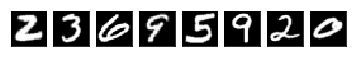

In [154]:
# TODO:  Plot 8 random samples from the training data of the digits

samples = 8
nsamp = Xtr_dig.shape[0]
Iperm = np.random.permutation(nsamp)

for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,samples,i+1)
    plt_char(Xtr_dig[ind,:])


Next, plot 8 samples from the letters training data.  You should see that the labels go from 0 to 25 corresponding to `a` to `z`.  Upper and lower case letters belong to the same class.

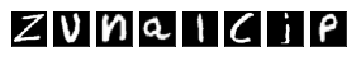

In [155]:
# TODO:  Plot 8 random samples from the training data of the letters
samples = 8
nsamp = Xtr_let.shape[0]
Iperm = np.random.permutation(nsamp)

for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_char(Xtr_let[ind,:])

## Creating a Non-Digit Class

SVM classifiers are VERY SLOW to train.  The training is particularly slow when there are a large number of classes, since the one classifier must be trained for each pair of labels.  To make the problem easier, we are going to lump all of the letters in one class and add that class to the digits.  

Before we begin, we first need to remove all the letters corresponding to `i/I`, `l/L` and `o/O`.  The reason is that these letters would get confused with the digits `0` and `1`.  Create arrays `Xtr_let_rem` and `ytr_let_rem` from the data `Xtr_let` and `ytr_let`, where the samples `i` with `ytr_let[i] == 9, 12` or `15` are removed.   Create `Xts_let_rem` and `yts_let_rem` similarly.

If you are clever, you can do this without a for-loop via python broadcasting and `np.all(..., axis=1)` command.  But, you will receive full marks if you use a `for-loop`.

In [157]:

v = np.where(ytr_let == 9)
v1 = np.where(ytr_let == 12)
v2 = np.where(ytr_let == 15)
rem_arr = v+v1+v2

Xtr_let_rem = np.delete(Xtr_let, rem_arr, axis=0)
ytr_let_rem = np.delete(ytr_let, rem_arr, axis=0)

v = np.where(yts_let == 9)
v1 = np.where(yts_let == 12)
v2 = np.where(yts_let == 15)
rem_arr = v+v1+v2

Xts_let_rem = np.delete(Xts_let, rem_arr, axis=0)
yts_let_rem = np.delete(yts_let, rem_arr, axis=0)


Since training and testing an SVM is VERY SLOW, we will use only a small subset of the training and test data.  Of course, you will not get great results with this small dataset.  But, we can at least illustrate the basic concepts.  

Create arrays `Xtr1_dig` and `ytr1_dig` by selecting 5000 random training digit samples from `Xtr_dig` and `ytr_dig`.  Create arrays `Xtr1_let` and `ytr1_let` by selecting 1000 random training letter samples from `Xtr_let_rem` and `ytr_let_rem`.  Similarly, create test arrays `Xts1_dig,Xts1_let,yts1_dig,yts1_let` with 5000 digits and 1000 letters.

In [158]:
# Number of training and test digits and letters
ntr_dig = 5000
ntr_let = 1000
nts_dig = 5000
nts_let = 1000

# TODO Create sub-sampled training and test data
nsamp = Xtr_dig.shape[0]
Iperm = np.random.permutation(nsamp)

Xtr1_dig = Xtr_dig[Iperm[:ntr_dig],:]
ytr1_dig = ytr_dig[Iperm[:ntr_dig]]

nsamp = Xtr_let_rem.shape[0]
Iperm = np.random.permutation(nsamp)

Xtr1_let = Xtr_let_rem[Iperm[:ntr_let],:]
ytr1_let = ytr_let_rem[Iperm[:ntr_let]]

nsamp = Xts_dig.shape[0]
Iperm = np.random.permutation(nsamp)

Xts1_dig = Xts_dig[Iperm[:nts_dig],:]
yts1_dig = yts_dig[Iperm[:nts_dig]]

nsamp = Xts_let_rem.shape[0]
Iperm = np.random.permutation(nsamp)

Xts1_let = Xts_let_rem[Iperm[:nts_let],:]
yts1_let = yts_let_rem[Iperm[:nts_let]]
 

Next, we create data by combining the digit and letter arrays.
* Create an array `Xtr` by stacking `Xtr1_dig`, `Xtr1_let`.  This should result in 6000 total samples.
* Create a new label vector `ytr` where `ytr[i] = ytr1_dig[i]` for any digit sample and `ytr[i]=10` for any letter sample.  Thus, all the letters are lumped into a single class with label 11.

Create test arrays `Xts` and `yts` similarly. 

You may wish to use the `np.hstack` and `np.vstack` methods.

In [159]:
# TODO:  Create combined letter and digit training and test data
Xtr = np.vstack((Xtr1_dig, Xtr1_let))
ytr = np.hstack((ytr1_dig, 10*np.ones(1000)))

Xts = np.vstack((Xts1_dig, Xts1_let))
yts = np.hstack((yts1_dig, 10*np.ones(1000)))

The training data above takes values from 0 to 255.  Rescale the data from -1 to 1.  This will get slightly better performance on the SVM.  Save the scaled data into arrays `Xtr1` and `Xts1`.

In [160]:
# TODO:  Rescale the data from -1 to 1
Xtr1 = Xtr/255.0*2 - 1
Xts1 = Xts/255.0*2 - 1

## Run the SVM classifier

First create the SVM classifer. Use an `rbf` classifier with `C=2.8` and `gamma=.0073`. We will look at how to select these parameters laters.

In [161]:
from sklearn import svm

# TODO:  Create a classifier: a support vector classifier
svc = svm.SVC(probability=False, kernel="rbf", C=2.8, gamma=.0073,verbose=10)

Fit the classifier using the scaled training data.  SVMs are insanely slow to train.  But, in this lab, we have kept the training size very small. So, the fitting should take about a minute or two.

In [162]:
# TODO:  Fit the classifier on the training data. 
svc.fit(Xtr1,ytr)

[LibSVM]

SVC(C=2.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0073, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=10)

Measure the accuracy on the test data.  This too will take another huge amount of time.  Print the accuracy.  If you did everything right, you should get an accuracy of around 89%.

In [163]:
# TODO:  Measure error on the test data
from sklearn.metrics import accuracy_score

y_pred = svc.predict(Xts1)
acc = accuracy_score(yts,y_pred)

error_rate = 1 - acc
print("Accuracy on the test data =",acc)
print("Error data on the test data =",error_rate)

Accuracy on the test data = 0.9141666666666667
Error data on the test data = 0.08583333333333332


The error rate is quite a bit higher than what we got in the digits only case.  Actually, had we done a classifier using all 36 labels instead of collapsing the letters to a single class, the SVM classifier would have done much better.  The reason is that the "letters" class is now extremely complex.  

Print a confusion matrix.  You should see that the error rate on the "letters" class is much higher.

[[0.948 0.    0.    0.    0.002 0.002 0.    0.    0.004 0.    0.022]
 [0.    0.981 0.002 0.    0.    0.002 0.    0.    0.    0.    0.008]
 [0.    0.002 0.915 0.    0.    0.    0.    0.008 0.006 0.    0.037]
 [0.002 0.    0.004 0.921 0.    0.006 0.    0.002 0.014 0.    0.023]
 [0.    0.002 0.    0.    0.897 0.    0.    0.    0.    0.006 0.047]
 [0.    0.    0.    0.013 0.    0.896 0.    0.    0.002 0.002 0.042]
 [0.    0.004 0.    0.    0.    0.008 0.919 0.    0.    0.    0.032]
 [0.    0.    0.002 0.    0.004 0.    0.    0.953 0.    0.008 0.017]
 [0.002 0.004 0.004 0.002 0.002 0.004 0.    0.002 0.904 0.    0.038]
 [0.    0.    0.    0.009 0.004 0.002 0.    0.006 0.006 0.934 0.021]
 [0.028 0.017 0.034 0.017 0.028 0.077 0.019 0.006 0.03  0.048 0.848]]


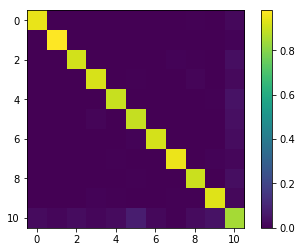

In [164]:
# TODO:  Print a confusion matrix
from sklearn.metrics import confusion_matrix
C = confusion_matrix(yts,y_pred)

# Normalize the confusion matrix
Csum = np.sum(C, axis = 1)
C =np.divide(C,Csum)

# Print the confusion matrix
print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

Print:
* What fraction of digits are mislabeled as letters?  
* What fraction of letters are mislabeled as digits?

In [173]:
# TODO:  Print above two error rates
err_digaslet = np.sum(C[:10,10])/11
err_letasdig = 1 - C[10,10] 
print("The fraction of digits are mislabeled as letters = %.3f" % err_digaslet )
print("The fraction of letters are mislabeled as digits = %.3f" % err_letasdig )

The fraction of digits are mislabeled as letters = 0.026
The fraction of letters are mislabeled as digits = 0.152


## Selecting gamma and C via Cross-Validation (Using For-Loops)

In the above example, and in the demo, we used a given `gamma` and `C` value.  The selection of the parameters depend on the problem and decent performance of the SVM requires that you select these parameters carefully.  The best way to select the parameters is via cross validation.  Specifically, generally, one tries different values of `gamma` and `C` and selects the pair of values the lowest test error rate.

In the code below, we will try to use 3 values for `C` and `gamma` as specified in the arrays `C_test` and `gam_test`.  For each `C` and `gamma` in these arrays, fit a model on the training data and measure the accuracy on the test data.  Then, print the `C` and `gamma` that result in the best accuracy.   

Normally, you would try a large number of values for each of the parameters, but an SVM is very slow to train -- even with this small data set.  So, we will just do 3 values of each.  Even then, this could take 30 minutes or so to complete. 

In this lab, you may do the parameter search over `C` and `gamma` in one of two ways:
* This section:  Use for loops and manually search over the parameters.  This is more direct and you will see and control exactly what is happening.
* Next section:  Use the `GridSearchCV` method in the `sklearn` package.  This takes a little reading, but once you learn this method, you can more easily use this for complex parameter searches.

**You only need to submit the solutions to one of the two sections.**  Pick whichever one you want.

In [166]:
C_test = [0.1,1,10]
gam_test = [0.001,0.01,0.1]

nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))

# TODO:  Measure and print the accuracy for each C and gamma value.  Store the results in acc
for i in range(nC):
    for j in range(ngam):
        svc = svm.SVC(probability=False, kernel="rbf", C= C_test[i], gamma=gam_test[j], verbose=10)
        svc.fit(Xtr1,ytr)
        y_pred = svc.predict(Xts1)
        acci = accuracy_score(yts,y_pred)
        acc[i,j] = acci


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [167]:
# TODO:  Print the accuracy matrix
print(acc)

[[0.79033333 0.5925     0.16666667]
 [0.87116667 0.891      0.2205    ]
 [0.89916667 0.89683333 0.22316667]]


In [169]:
# TODO:  Print the maximum accuracy and the corresponding best C and gamma

[Coptarg,gamOptarg] = np.unravel_index(np.argmax(acc, axis=None), acc.shape)
print("The maximum accuracy = %.6f" %acc[Coptarg,gamOptarg])
print("The corresponding value of C =", C_test[Coptarg])
print("The corresponding value of gamma =", gam_test[gamOptarg])



The maximum accuracy = 0.899167
The corresponding value of C = 10
The corresponding value of gamma = 0.001


## Using `GridSearchCV` (Optional Section)


In the previous section, you would have likely used `for-loops` to search over the different `C` and `gamma` values.  Since this type of parameter search is so commonly used, `sklearn` has an excellent method `GridSearchCV` that can perform all the operations for you.  In this lab, `GridSearchCV` is not that useful.  But, once you get to more complex parameter searches, the `GridSearchCV` method can save you writing a lot of code.  Importantly, `GridSearchCV` supports parallelization so that fits with different parameters can be fit at the same time.  In this optional section, we will show how to use this method.  

**You do not have to do this section, if you did the previous section**.  

The `GridSearchCV` method does the train-test split in addition to the parameter search.  In this case, you have already a fixed train-test split.  So, you first need to combine the train and test data back into a single dataset.

Create arrays `X` and `y` from `Xtr1`, `Xts1`, `ytr` and `yts`.  Use `np.vstack` and `np.hstack`.

In [23]:
# TODO:  Create combined trained and test data X and y.
# X = ...
# y = ...

Normally, `GridSearchCV` will do $K$-fold validation and automatically split the data into training and test in each fold.  But, in this case, we want it to perform only one fold with a specific train-test split.  To do this, we need to do the following:
* Create a vector `test_fold` where `test_fold[i] = -1` for the samples `i` in the training data (this indicates that they should not be used as test data in any fold) and `test_fold[i] = 0` for the samples `i` in the test data (this indicates that they should be as test data in fold 0).
* Call the method  `ps = sklearn.model_selection.PredefinedSplit(test_fold)` to create a predefined test split object.

In [24]:
# TODO:  Create a pre-defined test split object 
# import sklearn.model_selection
# test_fold = ...
# ps = sklearn.model_selection.PredefinedSplit(test_fold)

Next, read about the `GridSearchCV` method to set up a classifier that includes searching over the parameter grid.  
* For the `param_grid` parameter, you will want to create a dictionary to search over `C` and `gamma`.  You will also need to select the `kernel` parameter.
* Set `cv = ps` to use the fixed train-test split.
* Set `verbose=10` to monitor the progress

In [25]:
# TODO:  Create a GridSearchCV classifier
# clf = ...

Fit the classifier using the `fit` method.  The fit method will now search over all the parameters. This will take about 30 minutes.

In [26]:
# TODO: Fit the classifier

Print the `best_score_` and `best_params_` attributes of the classifier to find the best score and parameters

In [27]:
# TODO:  Print the best parameter and score of the classifier

Finally, you can print the test and train score from the `cv_results_['mean_test_score']` and `cv_results_['mean_train_score']`.

In [28]:
# TODO:  Print the mean test score for each parameter value.